# Requirements

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import os
import cv2
import glob
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")


# Load the images

In [10]:
# Define the path to the directory containing the images
path = "/home/stanley/Documents/facerecognition/FR"

labels = ['jack','stan','weimin']
# Load the images and labels into arrays
images = []
image_labels = []
for label in labels:
    image_paths = [os.path.join(path, label, f) for f in os.listdir(os.path.join(path, label)) if f.endswith('.jpg')]
    for image_path in image_paths:
        img = cv2.imread(image_path,0)
        img = cv2.resize(img, (200, 200)) # Resize the image to 200 x 200 pixels
        images.append(img)
        image_labels.append(label)

# Convert the image and label arrays to NumPy arrays
images = np.array(images)
image_labels = np.array(image_labels)


# Normalize and make it One Dimension

In [11]:
#Normalize the image array, the image vector values will be between 0 and 1. Convert to numpy array to perform mathematical expressions.

#convert the image into 1D array, 
image_vectors = np.array([img.flatten() for img in images])
print(image_vectors.shape)

mean = np.mean(image_vectors, axis=0)
std = np.std(image_vectors, axis=0)

# normalize the image vectors by subtracting the mean and dividing by the standard deviation
image_vectors_norm = (image_vectors - mean) / std

# image_vectors.shape

(3000, 40000)


# Perform PCA

In [12]:
# # create a PCA object
# pca = PCA(n_components=31)  # set the number of components you want to keep

# # fit the PCA model to the image vectors
# pca.fit(image_vectors)

# # transform the image vectors to their low-dimensional representation
# image_vectors_transformed = pca.transform(image_vectors)
# print(image_vectors_transformed.shape)
# # plot the transformed data with the first two principal components as the x and y axes
# plt.scatter(image_vectors_transformed[:, 0], image_vectors_transformed[:, 1])

# # plot the first principal component as a line passing through the scatter plot
# x = np.linspace(-5, 5)
# y = x * pca.components_[0, 1] / pca.components_[0, 0]
# plt.plot(x, y, color='r')

# plt.show()

# Perform LDA

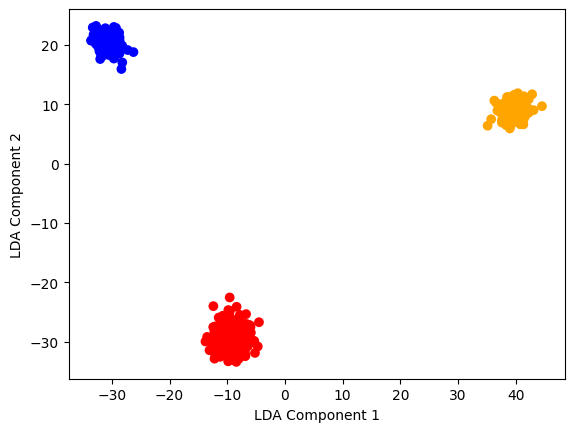

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

color_dict = {
              'jack': 'blue',
              'stan' : 'red',
              'weimin' : 'orange'

           }
# create an LDA object
lda = LinearDiscriminantAnalysis(n_components=2)

# fit the LDA model to the image vectors
lda.fit(image_vectors, image_labels)

# transform the image vectors to their low-dimensional representation
image_vectors_transformed = lda.transform(image_vectors)

colors = [color_dict[label] for label in image_labels]


# create a scatter plot of the transformed image vectors, using the image_labels to assign a unique color to each label
plt.scatter(image_vectors_transformed[:, 0], image_vectors_transformed[:, 1], c=colors)
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.show()


In [14]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import accuracy_score

# # Create a list of the number of components to try
# n_components_list = [1, 2, 3, 4, 5]

# # Create a KFold object for 5-fold cross-validation
# kf = KFold(n_splits=5)

# # Loop over each value of n_components
# for n_components in n_components_list:
#     # Create an LDA object with the current number of components
#     lda = LinearDiscriminantAnalysis(n_components=n_components)

#     # Initialize a list to store the accuracy for each fold
#     accuracies = []

#     # Loop over each fold of the data
#     for train_idx, test_idx in kf.split(image_vectors):
#         # Split the data into training and test sets
#         X_train, X_test = image_vectors[train_idx], image_vectors[test_idx]
#         y_train, y_test = image_labels[train_idx], image_labels[test_idx]

#         # Fit the LDA model to the training data and transform the test data
#         lda.fit(X_train, y_train)
#         X_test_transformed = lda.transform(X_test)

#         # Predict the labels for the test data and compute the accuracy
#         y_pred = lda.predict(X_test_transformed)
#         accuracy = accuracy_score(y_test, y_pred)
#         accuracies.append(accuracy)

#     # Compute the average accuracy across all folds
#     mean_accuracy = np.mean(accuracies)

#     # Print the number of components and the mean accuracy
#     print("n_components: {}, accuracy: {:.3f}".format(n_components, mean_accuracy))


# KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_vectors_transformed, image_labels, test_size=0.2, random_state=42)

# Create a kNN classifier with k=5
knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier on the training data
knn.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = knn.predict(X_test)

# Print the accuracy of the classifier
print("Accuracy:", np.mean(y_pred == y_test))


Accuracy: 1.0


# Viola Jones

In [16]:
# Open the default camera
cap = cv2.VideoCapture(0)
N = 10
last_faces = []

while True:
    # Read the next frame from the camera
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame using the Haar cascade classifier
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    last_faces.append(faces)
    if len(last_faces) > N:
        last_faces.pop(0)

    if last_faces:
        x = sum([face[0] for faces in last_faces for face in faces]) // len(last_faces)
        y = sum([face[1] for faces in last_faces for face in faces]) // len(last_faces)
        w = sum([face[2] for faces in last_faces for face in faces]) // len(last_faces)
        h = sum([face[3] for faces in last_faces for face in faces]) // len(last_faces)

        # For each detected face, recognize the person and draw a rectangle around the face
    for (x, y, w, h) in faces:
            # Crop the detected face from the frame and resize it to the same size as the face images used during training
            face = gray[y:y+h, x:x+w]
            face_resized = cv2.resize(face, (200, 200))

            # Apply the same PCA transformation to the cropped and resized face to get the feature vector for that face
            face_vector = face_resized.flatten().reshape(1, -1)
    #         face_vector_transformed = pca.transform(face_vector)
            face_vector_transformed = lda.transform(face_vector)

            # Use the kNN classifier to predict the identity of the person based on the feature vector
            predicted_label = knn.predict(face_vector_transformed)[0]

            # Draw a rectangle around the detected face and display the predicted label on the rectangle
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame, predicted_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow("Recognition", frame)
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
